In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install pytorch-lightning
!pip install timm
!pip install comet-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 23.3 MB/s 
     |████████████████████████████████| 529 kB 57.9 MB/s 
     |████████████████████████████████| 125 kB 71.0 MB/s 
     |████████████████████████████████| 87 kB 3.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=d34854683e14dc30642d13c9a40b6c9d472c38c5e30c2388eccb98ede0c3bb78
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 22.8 MB/s 
     |████████████████████████████████| 182 kB 71.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 20.6 MB/s 
     |███████████

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import cv2
from sklearn.metrics import f1_score, roc_curve
import torch
import torch.nn as nn

import pytorch_lightning as pl
import timm

In [5]:
ROOT_DIR = "/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection"
GROUP_DIR = f"{ROOT_DIR}/data/Zalo22/LivenessDetection"

os.chdir(ROOT_DIR)

# Train

In [ ]:
# import shutil
# shutil.rmtree("/content/train")

In [6]:
import zipfile
with zipfile.ZipFile(f"{GROUP_DIR}/data/train.zip", 'r') as zip_ref:
    zip_ref.extractall(f"/content")

# import zipfile
# with zipfile.ZipFile(f"{GROUP_DIR}/data/public_test.zip", 'r') as zip_ref:
#     zip_ref.extractall(f"/content/public_test")

In [8]:
!python train.py --transform_config "config_v5" \
                --data_dir "/content/train" \
                --split_path "/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/data/Zalo22/LivenessDetection/data/meta_data/identified_metadata.csv" \
                --face_crop_path "/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/data/frame14_fd.csv" \
                --log_dir "/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/checkpoints" \
                --model_name "2D_singleframe" --version_name "size384_cropface" \
                --backbone "tf_efficientnetv2_s_in21ft1k" \
                --accelerator "cuda" \
                --batch_size 16 --num_epochs 30 \
                --height 384 --width 384 \
                --ext "mp4" --num_frames 1 --crop_face True \
                --fold 0


Use 1 frame | Load image from mp4 | Face crop True
Use 1 frame | Load image from mp4 | Face crop False
CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Number of datapoints | train: 905 | valid: 96
Use 1 frames
Model: 2D_singleframe | Version: ec36e40100e94521afe6a4f9a931acae
Log path: /content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/checkpoints/2D_singleframe_tf_efficientnetv2_s_in21ft1k/size384_cropface
Config: {'transform_config': 'config_v5', 'data_dir': '/content/train', 'split_path': '/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/data/Zalo22/LivenessDetection/data/meta_data/identified_metadata.csv', 'face_crop_path': '/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/data/frame14_fd.csv', 'log_dir': '/content/drive/My Drive/Colab_Notebooks/Zalo2022_LivenessDetection/checkpoints

# Infer

In [ ]:
weight_path = "./lightning_logs/baseline_2D/epoch=5-val_loss=8.64.ckpt"


# Others

In [ ]:
# import sys
# sys.path.append(ROOT_DIR)

from models import LivenessModel2D, LivenessModel2DLSTM
from datasets import LivenessDataset

import importlib
cfg = importlib.import_module("configs.config_v1").CFG

In [ ]:
train_data_dir = f"{ROOT_DIR}/data/train"

data_df = pd.read_csv(f"{ROOT_DIR}/data/label_with_folding.csv")
train_df = data_df[data_df['fold']!=1].reset_index(drop=True)
valid_df = data_df[data_df['fold']==1].reset_index(drop=True)

train_dataset = LivenessDataset(df=train_df, root_dir=train_data_dir, ext=cfg.ext, transforms=cfg.train_transforms, num_frames=3)
valid_dataset = LivenessDataset(df=valid_df, root_dir=train_data_dir, ext=cfg.ext, transforms=cfg.val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True,
                                            num_workers=cfg.num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=False,
                                            num_workers=cfg.num_workers)

In [ ]:
model = LivenessModel2DLSTM(cfg)

In [ ]:
x, _ = next(iter(train_loader))
model(x).shape

torch.Size([4, 1])

## Train val split

In [ ]:
os.listdir(f"{ROOT_DIR}/data")

['Zalo22', 'train', 'public', 'train_metadata.csv', 'label_with_folding.csv']

In [ ]:
train_metadata = pd.read_csv(f"{ROOT_DIR}/data/train_metadata.csv").rename(columns={"img_name":"fname"})
folding_df = pd.read_csv(f"{ROOT_DIR}/data/label_with_folding.csv")
data_df = folding_df.merge(train_metadata, on = ["fname"])
data_df.head()

,Unnamed: 0_x,fname,liveness_score,fold,Unnamed: 0_y,width,height,duration,frame_count,FPS
0,0,1.mp4,0,2,0,480.0,852.0,5.06,126.0,24.92
1,1,2.mp4,1,4,1,1080.0,1920.0,5.04,121.0,24.00
2,2,3.mp4,1,3,2,2160.0,3840.0,5.06,162.0,32.00
3,3,5.mp4,0,2,3,1080.0,1920.0,5.00,160.0,32.00
4,4,7.mp4,1,3,4,720.0,1280.0,5.00,145.0,29.00


(array([461.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 472.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

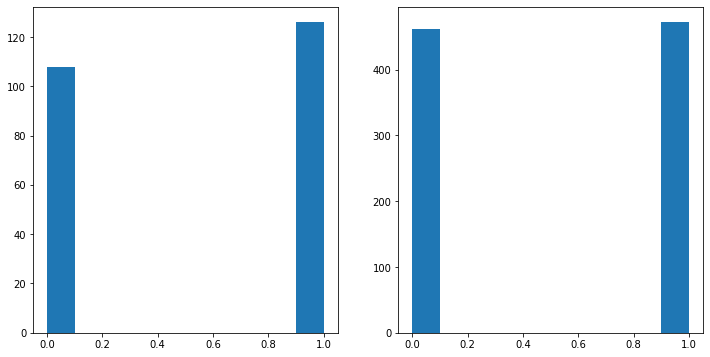

In [ ]:
feature = "liveness_score"

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.hist(data_df[data_df.fold == 0][feature])

plt.subplot(1,2,2)
plt.hist(data_df[data_df.fold != 0][feature])

## Metric

In [ ]:
from sklearn.metrics import roc_curve

from utils import equal_error_rate

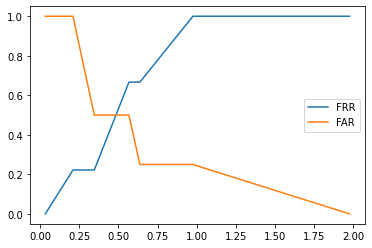

(0.5, 0.5676940460743075)

In [ ]:
gts = np.array([1,1,1,0,0,1,1,1,1,0,0,1,1])
preds = np.array([np.random.rand() for i in range(gts.shape[0])])
equal_error_rate(gts,preds,plot=True)

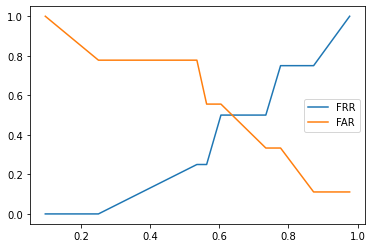

In [ ]:
_filter = threshold <= 1
plt.plot(threshold[_filter], fnr[_filter], label='FRR')
plt.plot(threshold[_filter], fpr[_filter], label='FAR')
plt.legend()
plt.show()

In [ ]:
np.random.rand()

0.18094036830340532